### <p style="text-align: right;"> &#9989; Nathan Kurt</p>

# Using Sentiment Analysis On Fallout 76 Tweets

A while back I was browsing Reddit and Youtube when I noticed that people really seem to hate Fallout 76. This didn't seem like some normal everyday hate, it seemed like this game had killed their Uncle Ben or something. I also remember seeing a lot of cool libraries for Twitter that can get data off of them and other libraries that can analyze the tweets. 

So I wanted to see if everyone on Twitter felt the same about Fallout 76 as the people with high klout on review sites, Reddit, and Youtube did. I ended up analyzing the data using a sentiment analysis and polarity scores to tell everything. 

In [4]:
import tweepy #A library that's pretty helpful for using the twitter API
from os import environ #So i can grab env vars
import re #re is the basic package used for RegEx stuff
import numpy as np 
import pandas as pd
#Basically a sentiment analyzer 
from textblob import TextBlob
import glob #glob lets me, well, glob things together 
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates

In [5]:
testimonial = TextBlob("Red Dead Redemption")
print(testimonial.sentiment)
print("Red Dead Redemption Control: ", testimonial.sentiment.polarity)
fallout = TextBlob("Fallout 76")
print("Fallout 76 Control: ", fallout.sentiment.polarity)


Sentiment(polarity=-0.1, subjectivity=0.2)
Red Dead Redemption Control:  -0.1
Fallout 76 Control:  0.0


Using Red Dead as a control works, but I have to add .1 to the sentiment analysis because the word "Dead" in the title lowers things quite a bit and we want to make them both start out at neutral

# The Clean but Expensive Way

In [6]:
class TwitterClient(object):

    def __init__(self):
        #These are the keys needed to gather the data from the twitter api
        #This only works on my system because the keys are in my environment, it won't work for everyone
        consumer_key = environ['consumer_key_twitter']
        consumer_key_secret = environ['consumer_secret_twitter']
        access_token = environ['access_token_twitter']
        access_token_secret = environ['access_token_secret_twitter']

        try:
            #Create auth object
            self.auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret)

            #Setting access toekn and secret
            self.auth.set_access_token(access_token, access_token_secret)

            self.api = tweepy.API(self.auth)
        except:
            print("Error: Authentication Failed")

    #Credit to https://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/ for this function
    def clean_tweet(self, tweet): 
            ''' 
            Utility function to clean tweet text by removing links, special characters 
            using simple regex statements. 
            '''
            
            return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) | (\w+:\/\/\S+)", " ", tweet).split()) 


    #This is for the sentiment raw score
    def get_sentiment_score(self, tweet):
        analysis = TextBlob(self.clean_tweet(tweet))
        #Set sentiment
        return analysis.sentiment.polarity

   
    """
    The main function to get tweets
    """
    def get_tweets(self, query, count = 10):
        tweets = []

        try: 

            search = self.api.search(q = query, count = count, lang = "en")
            for tweet in search:
                # empty dict to store required params of a tweet
                parsed_tweet = {}

                #saving text of tweet
                parsed_tweet['text'] = tweet.text

                #saving sentiment 
                parsed_tweet['sentiment_score'] = self.get_sentiment_score(tweet.text)

                if parsed_tweet['sentiment_score'] > 0:
                    parsed_tweet['sentiment_type'] = "positive"
                elif parsed_tweet['sentiment_score'] == 0:
                    parsed_tweet['sentiment_type'] = "neutral"
                else:
                    parsed_tweet['sentiment_type'] = "negative"

                #saving Likes
                parsed_tweet['likes'] = tweet.favorite_count

                #saving the time it was created
                parsed_tweet['Time'] = tweet.created_at

                #saving RTs 
                parsed_tweet['retweets'] = tweet.retweet_count

                if tweet.retweet_count > 0:
                    #want to make sure that they only get appended to the list once
                    if parsed_tweet not in tweets:
                        tweets.append(parsed_tweet)
                else:
                    tweets.append(parsed_tweet)

            return tweets


        #there's an error here so list it
        except tweepy.TweepError as e:
            print("Error : " + str(e))


In [7]:
api = TwitterClient()

tweets = api.get_tweets(query = "Fallout 76", count = 200)

ptweets = [tweet for tweet in tweets if tweet['sentiment_type'] == 'positive'] 
# percentage of positive tweets 
print("Positive tweets percentage: {} %".format(100*len(ptweets)/len(tweets))) 
# picking negative tweets from tweets 
ntweets = [tweet for tweet in tweets if tweet['sentiment_type'] == 'negative'] 
# percentage of negative tweets 
print("Negative tweets percentage: {} %".format(100*len(ntweets)/len(tweets))) 
# percentage of neutral tweets 
print("Neutral tweets percentage: {} %".format(100*(len(tweets) - len(ntweets) - len(ptweets))/len(tweets)))  



Positive tweets percentage: 54.0 %
Negative tweets percentage: 19.0 %
Neutral tweets percentage: 27.0 %


** To clarify why this may seem high while the others don't seem nearly as high:** Bethesda recently announced that they are trying to fix their mistake with the nylon bags and actually send the canvas bags. So right now, people seem to like them because they are.. _giving the people what they paid for in the first place_? 

In [8]:
# printing first 5 positive tweets 
print("\nPositive tweets:") 
for tweet in ptweets[:2]: 
    print(tweet['text']) 

# printing first 5 negative tweets 
print("\n\nNegative tweets:") 
for tweet in ntweets[:2]: 
    print(tweet['text']) 


Positive tweets:
Check out my broadcast from my PlayStation 4! #PS4live (Fallout 76)  live at https://t.co/c6PLjLOyuq
I liked a @YouTube video https://t.co/RoPEIajz18 Fallout 76 Farming Crafting materials ULTIMATE GUIDE ! | fastest way to get xo1 armor


Negative tweets:
So it seems like this Fallout 76 update included several "hidden" changes (things not in the patch notes). Such as… https://t.co/bNrPZGWU4r
Every time I die in @Fallout 76 I have to start over because there is no reason I wouldn't just be dead.  Life 16 is next.


This works really well, the only problem with this tweeper API Is that you can't get anything from more than seven days ago. Pretty lame if you ask me. This has the most potential though and is the best way to grab data so **I'll keep it up here while I attempt a more hack-y way of doing this** 

# The Hacky Way
First we need to get the old Tweets, since tweepy only allows you to get seven days worth of tweets back, we're kind of hosed with that. 
I found a web scraper that works for the most part on [GitHub](https://github.com/Jefferson-Henrique/GetOldTweets-python). I had to change it up though because it would get tweets that are in other languages, didn't actually work for Python 3 because of things like print being a function now vs a statement before. Also I'm not going to use Python 2 because it's 2018 people, come on! Python 3 has been around for 10 years now! 

If you want to take a look at the script, you can find it in the zip file

In [4]:
cmd = "python3 GetOldTweets-python/Exporter.py --query = 'Fallout 76' --maxtweets = 1000000 --output fallouttweets.csv --since 2018-11-14 --until 2018-11-15 "
#!{cmd} Don't do this yet
#This creates the tweets and saves it to a file name that you enter. 

Since running this with `maxtweets` set to something high like 100000 would only get the data from the most recent 10000 tweets, I had to run the script multiple times and change the max and min dates. 

So I made a function that got a start date and how many days you wanted, then used f strings(new in Python 3.6 and much nicer than .format) to change the name of the files and run the script mutliple times. 

In [3]:
def get_csvs(query = "Fallout 76", start="2018-11-14", days=18, filename="tweets.csv", maxtweets=1000, run=False):
    
    filename = filename.split(".")
    start_list = start.split("-")
    date = datetime.datetime(int(start_list[0]),int(start_list[1]),int(start_list[2]))
    date_list = [date]
    for i in range(days+1): 
        date += datetime.timedelta(days=1)
        date_list.append(date)

    date_list_string = [datetime.datetime.strftime(i, "%Y-%m-%d") for i in date_list]
    
    i = 0
    while(i < len(date_list_string)-1):
        cmd = f"python3 GetOldTweets-python/Exporter.py --query '{query}' --maxtweets {maxtweets} --output '{filename[0]+date_list_string[i]}.{filename[1]}' --since {date_list_string[i]} --until {date_list_string[i+1]}"
        i += 1
        
        if run:
            !{cmd}
        else:
            print(cmd)
        
#setting this to false because I already have the tweets and moved them to a folder for each thing. 
get_csvs(run=False)
    

python3 GetOldTweets-python/Exporter.py --query 'Fallout 76' --maxtweets 1000 --output 'tweets2018-11-14.csv' --since 2018-11-14 --until 2018-11-15
python3 GetOldTweets-python/Exporter.py --query 'Fallout 76' --maxtweets 1000 --output 'tweets2018-11-15.csv' --since 2018-11-15 --until 2018-11-16
python3 GetOldTweets-python/Exporter.py --query 'Fallout 76' --maxtweets 1000 --output 'tweets2018-11-16.csv' --since 2018-11-16 --until 2018-11-17
python3 GetOldTweets-python/Exporter.py --query 'Fallout 76' --maxtweets 1000 --output 'tweets2018-11-17.csv' --since 2018-11-17 --until 2018-11-18
python3 GetOldTweets-python/Exporter.py --query 'Fallout 76' --maxtweets 1000 --output 'tweets2018-11-18.csv' --since 2018-11-18 --until 2018-11-19
python3 GetOldTweets-python/Exporter.py --query 'Fallout 76' --maxtweets 1000 --output 'tweets2018-11-19.csv' --since 2018-11-19 --until 2018-11-20
python3 GetOldTweets-python/Exporter.py --query 'Fallout 76' --maxtweets 1000 --output 'tweets2018-11-20.csv' --

After running the script, I went ahead and put the CSVs into their own folder so it didn't look to hectic and globbed them together using the glob library and turned it into one big CSV file since each tweet has a date associated with it anyways 

In [9]:

path = "GetOldTweets-python/CSVs"
allFiles = glob.glob(path + "/*.csv")

list_ = []

for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0, delimiter=";")
    list_.append(df)

data = pd.concat(list_, axis = 0, ignore_index = True)

#data = pd.read_csv(f"GetOldTweets-python/CSVs/output_got21.csv", delimiter=";")

data.head()

,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink
0,NaN,2018-11-23 18:59,0,0,I pre ordered and bought Fallout 76 for Alan a...,NaN,NaN,NaN,1066119195216306176,https://twitter.com/_alliebeloat_/status/10661...
1,NaN,2018-11-23 18:59,0,6,"Wonderful time today w/ @ Torbin_GG, @ SmartAS...",NaN,@ @ @ @ @,#,1066119192586436613,https://twitter.com/hollowxcore/status/1066119...
2,NaN,2018-11-23 18:59,0,0,I bought Fallout 76 on the Bethesda site for £...,NaN,NaN,NaN,1066119163868000258,https://twitter.com/Roufonn/status/10661191638...
3,NaN,2018-11-23 18:59,0,0,A Player Marketplace would be cool you can set...,NaN,NaN,NaN,1066119139973099520,https://twitter.com/TopNotchCoopa/status/10661...
4,NaN,2018-11-23 18:59,0,4,Sure honeypic.twitter.com/6Ada2TCy0W,NaN,NaN,NaN,1066119080984367104,https://twitter.com/_armylands/status/10661190...


Just getting this data about Fallout 76 won't tell us that much if there isn't a benchmark to compare it to. So I'll use the game Red Dead Redemption 2 to compare it to. Both of these games came out at roughly the same time, so if Twitter really does feel the same way about the game as Reddit and review sites seem to feel, then Fallout 76 should have much sentiment scores than Red Dead Redemption 2. 

<p float="left"> <img src="fallout_metacritic.png" width="500">   <img src="red_dead_metacritic.png" width="500"> </p>

In [ ]:
get_csvs(query = "Red Dead", filename="reddeadtweets.csv")

In [42]:
path = "GetOldTweets-python/Red-Dead-CSVs"
allFiles = glob.glob(path + "/*.csv")

list_ = []

for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0, delimiter=";")
    list_.append(df)

red_dead_data = pd.concat(list_, axis = 0, ignore_index = True)

red_dead_data.head()

,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink
0,NaN,2018-11-23 18:59,0,0,HOW DID YOU GET THAT HORSE?!?!?!! i need to know,NaN,NaN,NaN,1066119194784206848,https://twitter.com/Erdem_D_/status/1066119194...
1,NaN,2018-11-23 18:59,0,1,HUGE RED DEAD REDEMPTION 2 SPOILER I swear to ...,NaN,NaN,NaN,1066119164115542018,https://twitter.com/fallawaycamila/status/1066...
2,NaN,2018-11-23 18:59,0,1,The worst part is when you manage to get 3hits...,NaN,NaN,NaN,1066119100869500928,https://twitter.com/sk3ach/status/106611910086...
3,NaN,2018-11-23 18:59,0,0,RDR2 Cheats: FINAL Red Dead Redemption 2 codes...,NaN,NaN,NaN,1066119026584227842,https://twitter.com/D2webservices/status/10661...
4,NaN,2018-11-23 18:59,0,0,"Sorry, ‘Red Dead Redemption 2’ — the new ‘Call...",NaN,NaN,#Echobox,1066119014349455361,https://twitter.com/BusInsiderSG/status/106611...


We have the data now but it's pretty raw and I'd like to do some things with it. **RegEx to the resuce!!**

In [11]:
def clean_tweet(tweet): 
    ''' 
    Utility function to clean tweet text by removing links, special characters 
    using simple regex statements. 
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) | (\w+:\/\/\S+)", " ", tweet).split()) 


"""
I used this function because the output returns the tweet date as a string and datenumber
library can interpret that well but matplotlib is much better when it's a matplotlib number 
and there is already a function for datetime to matplotlib object
"""
def convert_string_to_datenumber(string):
    return mdates.date2num(pd.to_datetime(string))


## Naive Bayes Classifier

Now that we are set to be able to do stuff with this data, we'll do just that! 

We are using the [TextBlob](https://github.com/sloria/TextBlob) library in order to run sentiment analysis. We are going to be using the Naive Bayes classifier which relies on data that has already been deemed true. Thankfully TextBlob uses the [NLTK](https://www.nltk.org/) library which has a ton of data you can grab already. We'll be using the data found on the NLTK site([data](https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/movie_reviews.zip) if you want to take a look for yourself) But with TextBlob we can install all the data we need by running `python -m textblob.download_corpora` in a shell. 



The Naive Bayes Classifier is a way we can classify text that makes a large assumption: **every word in the sentence given is independent from each other** so for example if a tweet was just

$$ P(Fallout 76) = P(Fallout) * P(76) $$

Which also means we can assume 

$$ P(Fallout 76 | Positive) = P(Fallout | Positive) * P(76 | Positive) $$

Then we do the same thing for those words but with Negative and Neutral insted of Positive. 

The data given to us by the corpora has lots of movie review it uses that are both positive and negative with a sentiment score associated to each one. so the classifier looks at 
 
whichever one is higher is where it's classified. If it is classified as neutral, it automatically has a polarity score of 0. But if it has a positive or negative value then it is assigned a polarity score between -1 and 0 or 0 to 1.

The higher the number the more positive the tweet



In [12]:
#This is for the sentiment raw score
def get_sentiment_score(tweet):
    analysis = TextBlob(clean_tweet(tweet))
    #Set sentiment
    return analysis.sentiment.polarity

#This gets the type of sentiment 
def get_sentiment_type(score):
    if score > 0:
        return "positive"
    elif score == 0:
        return "neutral"
    else:
        return "negative"


In [24]:
#This cleans up the tweets for sentiment stuff you can do.
data['parsed_text'] = pd.Series([clean_tweet(tweet) for tweet in data["text"]], index=data.index)
red_dead_data['parsed_text'] = pd.Series([clean_tweet(tweet) for tweet in red_dead_data["text"]], index=red_dead_data.index)

In [25]:
#adding rows for sentiment score and type so i can use that later. going off of parsed text row
data["sentiment_score"] = pd.Series([get_sentiment_score(tweet) for tweet in data["parsed_text"]])
data["sentiment_type"] = pd.Series([get_sentiment_type(score) for score in data["sentiment_score"]])

red_dead_data["sentiment_score"] = pd.Series([get_sentiment_score(tweet) +.1 for tweet in red_dead_data["parsed_text"]])
red_dead_data["sentiment_type"] = pd.Series([get_sentiment_type(score) for score in red_dead_data["sentiment_score"]])

In [26]:

data["datenumber"] = pd.Series([convert_string_to_datenumber(i) for i in data["date"]])
red_dead_data["datenumber"] = pd.Series([convert_string_to_datenumber(i) for i in red_dead_data["date"]])


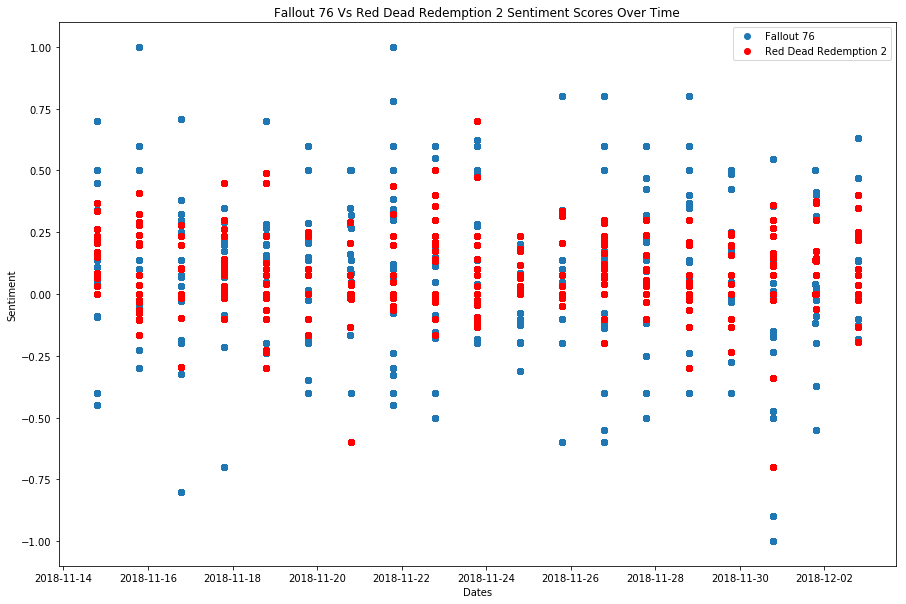

In [27]:
fig = plt.figure(figsize=(15,10))

plt.plot_date(data["datenumber"], data["sentiment_score"],label="Fallout 76")
plt.plot_date(red_dead_data["datenumber"], red_dead_data["sentiment_score"],label="Red Dead Redemption 2", color = "red")
plt.title("Fallout 76 Vs Red Dead Redemption 2 Sentiment Scores Over Time")
plt.xlabel("Dates")
plt.ylabel("Sentiment")
plt.legend()
plt.savefig("Original Image.png")
plt.show()


This shows something, like that Fallout 76 has more highs and lows while Red Dead Redemption 2 is more on the upper neutral side. It doesn't really tell me as much as i hoped it would though. The only real thing I can infer is that people seem to have strong feelings about Fallout 76 while Red Dead Redemption 2 is more neutral positive. 

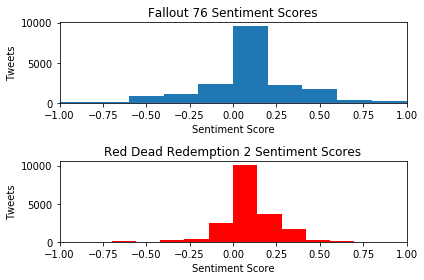

In [189]:
ax0 = plt.subplot(211)
ax0.hist(data["sentiment_score"])
ax0.set_xlim(-1,1)
ax0.set_title("Fallout 76 Sentiment Scores")
ax0.set_xlabel("Sentiment Score")
ax0.set_ylabel("Tweets")
ax1 = plt.subplot(212)
ax1.hist(red_dead_data["sentiment_score"], label="Red Dead", color = "red")
ax1.set_title("Red Dead Redemption 2 Sentiment Scores")
ax1.set_xlabel("Sentiment Score")
ax1.set_ylabel("Tweets")
plt.tight_layout()
ax1.set_xlim(-1,1)
plt.savefig("Fallout 76 vs Red Dead.png")
plt.show()

In [35]:
# picking positive tweets from tweets 

def print_tweet_percentages(data):
    ptweets = [tweet for tweet in data["sentiment_type"] if tweet == 'positive'] 
    # percentage of positive tweets ?
    print("Positive tweets percentage: {}%".format(100*len(ptweets)/len(data["sentiment_type"]))) 
    # picking negative tweets from tweets 
    ntweets = [tweet for tweet in data["sentiment_type"] if tweet == 'negative'] 
    # percentage of negative tweets 
    print("Negative tweets percentage: {}%".format(100*len(ntweets)/len(data["sentiment_type"])))                                                                                     
    # percentage of neutral tweets 
    print("Neutral tweets percentage: {}%".format(100*(len(data["sentiment_type"]) - len(ntweets) - len(ptweets))/len(data["sentiment_type"])))
    print(f"Max Sentiment Score: {max(data['sentiment_score'])}")
                                               
                                               
def get_tweet_percentages(data) -> tuple: 
    ptweets = [tweet for tweet in data["sentiment_type"] if tweet == 'positive'] 
    ntweets = [tweet for tweet in data["sentiment_type"] if tweet == 'negative'] 
    negative_percentage = 100*len(ntweets)/len(data["sentiment_type"])
    neutral_percentage = 100*(len(data["sentiment_type"]) - len(ntweets) - len(ptweets))/len(data["sentiment_type"])
    positive_percentage = 100*len(ptweets)/len(data["sentiment_type"]) 
                                               
    return(positive_percentage,negative_percentage,neutral_percentage)
print("\nFallout 76 Normal: ")
print_tweet_percentages(data)
print("\nRed Dead Redemption 2 Normal: ")
print_tweet_percentages(red_dead_data)


Fallout 76 Normal: 
Positive tweets percentage: 48.1578947368421%
Negative tweets percentage: 25.0%
Neutral tweets percentage: 26.842105263157894%
Max Sentiment Score: 1.0

Red Dead Redemption 2 Normal: 
Positive tweets percentage: 54.21052631578947%
Negative tweets percentage: 17.894736842105264%
Neutral tweets percentage: 27.894736842105264%
Max Sentiment Score: 0.7


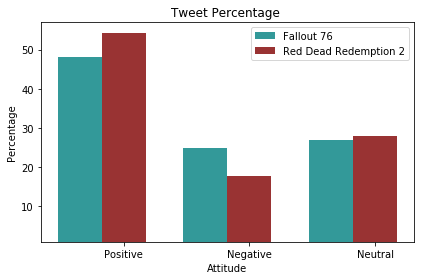

In [41]:
# data to plot
n_groups = 3
fallout_tweets = get_tweet_percentages(data)
red_dead_tweets = get_tweet_percentages(red_dead_data)
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, fallout_tweets, bar_width,
                 alpha=opacity,
                 color='Teal',
                 label="Fallout 76")
 
rects2 = plt.bar(index + bar_width, red_dead_tweets, bar_width,
                 alpha=opacity,color='Maroon',label='Red Dead Redemption 2')
 
plt.xlabel('Attitude')
plt.ylabel('Percentage')
plt.ylim(1)
plt.title('Tweet Percentage ')
plt.xticks(index + bar_width, ('Positive', 'Negative', 'Neutral'))
plt.legend()
 
plt.tight_layout()
plt.show()

# Conclusion

With such a small difference between sentiment scores for the two of these games, We're able to conclude that Twitter and the general population don't feel a great hatred for this game like Reddit and YouTube, and the people with higher Klout on Twitter make it out to be. 

It either shows that, or that it doesn't matter how well liked something seems to be, there will always be people on the internet to bash it. 

The issue with this model though is that even people only have about 80% accuracy with sentiment analysis so this model could have issues. 